In [24]:
def _int64_feature(value):
    """Wrapper for inserting int64 features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _float_feature(value):
    """Wrapper for inserting float features into Example proto."""
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def _bytes_feature(value):
    """Wrapper for inserting bytes features into Example proto."""
    # if isinstance(value, str):
        # value = value.encode('utf-8')
    
    # value = tf.io.serialize_tensor(value.numpy())
    print(value)
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _convert_to_example(image_example, image_buffer, height, width):
    """Build an Example proto for an example.
    Args:
      image_example: dict, an image example
      image_buffer: string, JPEG encoding of RGB image
      height: integer, image height in pixels
      width: integer, image width in pixels
    Returns:
      Example proto
    """

    # Required
    filename = str(image_example['filename'])
    id = str(image_example['id'])

    # Class label for the whole image
    image_class = image_example.get('class', {})
    class_label = image_class.get('label', 0)
    class_text = str(image_class.get('text', b''))

    # Bounding Boxes
    image_objects = image_example.get('object', {})
    image_bboxes = image_objects.get('bbox', {})
    xmin = image_bboxes.get('xmin', [])
    xmax = image_bboxes.get('xmax', [])
    ymin = image_bboxes.get('ymin', [])
    ymax = image_bboxes.get('ymax', [])
    bbox_labels = image_bboxes.get('label', [])
    bbox_scores = image_bboxes.get('score', [])
    bbox_count = image_bboxes.get('count', 0)

    # Parts
    image_parts = image_objects.get('parts', {})
    parts_x = image_parts.get('x', [])
    parts_y = image_parts.get('y', [])
    parts_v = image_parts.get('v', [])

    # Areas
    object_areas = image_objects.get('area', [])

    # Ids
    object_ids = image_objects.get('id', [])

    colorspace = b'RGB'
    channels = 3
    image_format = b'JPEG'

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': _int64_feature(height),
        'image/width': _int64_feature(width),
        'image/colorspace': _bytes_feature(colorspace),
        'image/channels': _int64_feature(channels),
        'image/class/label': _int64_feature(class_label),
        'image/class/text': _bytes_feature(class_text),
        'image/object/bbox/xmin': _float_feature(xmin),
        'image/object/bbox/xmax': _float_feature(xmax),
        'image/object/bbox/ymin': _float_feature(ymin),
        'image/object/bbox/ymax': _float_feature(ymax),
        'image/object/bbox/xyxy': _float_feature([xmin,ymin,xmax,ymax]),
        'image/object/bbox/label': _int64_feature(bbox_labels),
        'image/object/bbox/count': _int64_feature(bbox_count),
        'image/object/bbox/score': _float_feature(bbox_scores),
        'image/object/parts/x': _float_feature(parts_x),
        'image/object/parts/y': _float_feature(parts_y),
        'image/object/parts/v': _int64_feature(parts_v),
        'image/object/parts/count': _int64_feature(len(parts_v)),
        'image/object/area': _float_feature(object_areas),
        'image/object/id': _int64_feature(object_ids),
        'image/format': _bytes_feature(image_format),
        'image/filename': _bytes_feature(os.path.basename(filename)),
        'image/path': _bytes_feature(os.path.dirname(filename)),
        'image/id': _bytes_feature(str(id)),
        'image/encoded': _bytes_feature(image_buffer)}))
    return example

def _process_image(filename):
    """Process a single image file.
    Args:
      filename: string, path to an image file e.g., '/path/to/example.JPG'.
    Returns:
      image: string, JPEG encoding of RGB image.
      height: integer, image height in pixels.
      width: integer, image width in pixels.
    """

    # bring in the image, convert to MxNx3 uint tensor
    image = tf.io.decode_image(tf.io.read_file(filename), channels=3) 
    assert len(image.shape) == 3, 'Image must be 3 dimensions'
    height = image.shape[0]
    width = image.shape[1]
    assert image.shape[2] == 3, 'Image must have 3 channels, RGB'

    # convert it into a jpeg bytes-string -- pull the data out of the tensor!
    image_bytes = tf.io.encode_jpeg(image, quality=100).numpy()

    return image_bytes, height, width


def _process_image_files_batch(thread_index, ranges, name, output_directory, dataset, num_shards, error_queue):
    """Processes and saves list of images as TFRecord in 1 thread.
    Args:
      thread_index: integer, unique batch to run index is within [0, len(ranges)).
      ranges: list of pairs of integers specifying ranges of each batches to
        analyze in parallel.
      name: string, unique identifier specifying the data set (e.g. `train` or `test`)
      output_directory: string, file path to store the tfrecord files.
      dataset: list, a list of image example dicts
      num_shards: integer number of shards for this data set.
      error_queue: Queue, a queue to place image examples that failed.
    """
    # Each thread produces N shards where N = int(num_shards / num_threads).
    # For instance, if num_shards = 128, and the num_threads = 2, then the first
    # thread would produce shards [0, 64).
    num_threads = len(ranges)
    assert not num_shards % num_threads
    num_shards_per_batch = int(num_shards / num_threads)

    shard_ranges = np.linspace(ranges[thread_index][0],
                               ranges[thread_index][1],
                               num_shards_per_batch + 1).astype(int)
    num_files_in_thread = ranges[thread_index][1] - ranges[thread_index][0]

    counter = 0
    error_counter = 0
    for s in range(num_shards_per_batch):
        # Generate a sharded version of the file name, e.g. 'train-00002-of-00010'
        shard = thread_index * num_shards_per_batch + s
        output_filename = '%s-%.5d-of-%.5d' % (name, shard, num_shards)
        output_file = os.path.join(output_directory, output_filename)
        writer = tf.io.TFRecordWriter(output_file)

        shard_counter = 0
        files_in_shard = np.arange(shard_ranges[s], shard_ranges[s + 1], dtype=int)
        for i in files_in_shard:

            image_example = dataset[i]

            filename = str(image_example['filename'])

            try:
                image_buffer, height, width = _process_image(filename)

                example = _convert_to_example(image_example, image_buffer, height, width)
                writer.write(example.SerializeToString())
                shard_counter += 1
                counter += 1
            except Exception as e:
                raise
                error_counter += 1
                error_queue.put(image_example)

        shard_counter = 0


In [10]:
import tensorflow as tf
import keras_core as keras
import keras_cv
import os
from PIL import Image, ImageDraw
import numpy as np
import glob
from matplotlib import pyplot as plt

In [25]:
# import tensorflow as tf

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 64

In [5]:
def decode_func(record_bytes):
    # Parse an Example to access the Features
    example = tf.io.parse_single_example(
      record_bytes,
      features={
        # 'image/height': tf.io.FixedLenFeature([], tf.int64),
        # 'image/width': tf.io.FixedLenFeature([], tf.int64),
        # 'image/colorspace': tf.io.FixedLenFeature([], tf.string),
        # 'image/channels': tf.io.FixedLenFeature([], tf.int64),
        # 'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        # 'image/class/text': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/xyxy': tf.io.VarLenFeature(dtype=tf.float32),
        'image/object/bbox/label': tf.io.VarLenFeature(dtype=tf.int64),
        'image/object/bbox/count': tf.io.FixedLenFeature([], tf.int64),
        'image/object/bbox/score': tf.io.VarLenFeature(dtype=tf.float32),
        # 'image/object/parts/x': tf.io.VarLenFeature(dtype=tf.float32),
        # 'image/object/parts/y': tf.io.VarLenFeature(dtype=tf.float32),
        # 'image/object/parts/v': tf.io.VarLenFeature(dtype=tf.int64),
        # 'image/object/parts/count': tf.io.VarLenFeature(dtype=tf.int64),
        # 'image/object/area': tf.io.VarLenFeature(dtype=tf.float32),
        # 'image/object/id': tf.io.VarLenFeature(dtype=tf.int64),
        # 'image/format': tf.io.FixedLenFeature([], tf.string),
        # 'image/filename': tf.io.FixedLenFeature([], tf.string),
        # 'image/path': tf.io.FixedLenFeature([], tf.string),
        # 'image/id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string)
      }
    )

    bounding_boxes: {
            'boxes': tf.sparse_to_dense(example['image/object/bbox/xyxy']),
            'classes': tf.sparse_to_dense(example['image/object/bbox/label'])}
    images = tf.io.decode_jpeg(tf.sparse_to_dense(example['image/encoded']), channels=3)

    return (bounding_box, images)

    # image = tf.io.parse_single_example(
    #   record_bytes,
    #   features={
    #     'image/encoded': tf.io.FixedLenFeature([], tf.string)
    #   }
    # )

    # bbox = tf.io.parse_single_example(
    #   record_bytes,
    #   features={
    #     'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.float32),
    #     'image/object/bbox/ymin': tf.io.VarLenFeature(dtype=tf.float32),
    #     'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.float32),
    #     'image/object/bbox/ymax': tf.io.VarLenFeature(dtype=tf.float32),
    #     'image/object/bbox/label': tf.io.VarLenFeature(dtype=tf.int64),
    #     'image/object/bbox/count': tf.io.FixedLenFeature([], tf.int64),
    #     'image/object/bbox/score': tf.io.VarLenFeature(dtype=tf.float32)
    #   }
    # )
    
    # return (image, bbox)

def load_dataset(filenames):
    # allow the dataset to come in whenever
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)

    # map the function
    dataset = dataset.map(decode_func, num_parallel_calls=AUTOTUNE)

    # bbox_x0 = dataset['image/object/bbox/xmin']
    # bbox_y0 = dataset['image/object/bbox/ymin']
    # bbox_x1 = dataset['image/object/bbox/xmax']
    # bbox_y1 = dataset['image/object/bbox/ymax']

    # # create a tensor array of [xmin, ymin, xmax, ymax] for each bbox
    # bbox = tf.concat((bbox_x0, bbox_x1, bbox_y0, bbox_y1), axis=-1)
    # bbox = tf.transpose(bbox)

    # # pull out the image data
    # image = dataset['image/encoded']

    # return (image,bbox)
    return dataset


def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(1000,seed=42)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)

    return dataset




def show_batch(image_batch, label_batch):
    for n in range(4):
        im = Image.fromarray(tf.image.decode_jpeg(image_batch[n]))
        draw = ImageDraw.Draw(im)
        for bbox in label_batch[n]:
            draw.rectangle(bbox)
        im.show()


In [ ]:
# visualize the dataset

# get the data
os.chdir('/home/klb807/MARS_project/test/detection/black_top_tfrecords_detection')
train_files = glob.glob('./train_dataset*')
train_dataset = get_dataset(train_files)

cur_epoch = next(iter(train_dataset))

# print(tf.stack((cur_epoch['image/object/bbox/xmin'].values,
#           cur_epoch['image/object/bbox/xmax'].values,
#           cur_epoch['image/object/bbox/ymin'].values,
#           cur_epoch['image/object/bbox/ymax'].values),
#           axis=-1).numpy())


# print(cur_epoch['image/object/bbox/xmin'].values)

print(cur_epoch)



In [26]:
# prep the model
mdl = keras_cv.models.YOLOV8Detector(
    num_classes=16,
    bounding_box_format='xyxy',
    backbone=keras_cv.models.YOLOV8Backbone.from_preset('yolo_v8_m_backbone_coco'),
    fpn_depth=2
)

# mdl.compile(
#     classification_loss='binary_crossentropy',
#     box_loss='ciou',
#     optimizer=tf.optimizers.Adamax(),
#     jit_compile=False
# )


# # get the list of tfrecord files
# os.chdir('/home/klb807/MARS_project/test/detection/black_top_tfrecords_detection')

# train_files = glob.glob('./train_dataset*')

# train_dataset = tf.data.TFRecordDataset(train_files).map(decode_fn)

# # train the model
# mdl.fit()

# for image_fn in os.listdir('.'):
# # for image_fn in ['013009_A25_Block6_castBCma1_t_4677.png']:
#     if '.png' in image_fn:
#         with open(image_fn,'rb') as fid:
#             # bring in image data, create PIL image for later display
#             image_data = tf.image.decode_image(fid.read(),channels=3)
#             image_data = tf.image.resize_with_pad(image_data, 512, 512)
#             image_data = tf.expand_dims(image_data, axis=0)

#             output = mdl.predict(image_data)
            
#             # display the image and the bounding boxes 
#             im = Image.fromarray(np.squeeze(image_data.numpy()).astype(np.uint8))
#             draw = ImageDraw.Draw(im)
#             for i_box,box in enumerate(output['boxes'][0]):
#                 clrs = int(16*output['classes'][0][i_box])
#                 draw.rectangle(box, outline=(255-clrs, clrs, clrs, 0))
            
#             im.show()
#             i = input()

#             if i.lower() == 'stop':
#                 break



    

<class 'tensorflow.python.framework.ops.EagerTensor'>
(512, 512, 3)
1/1 [==============================] - 2s 2s/step


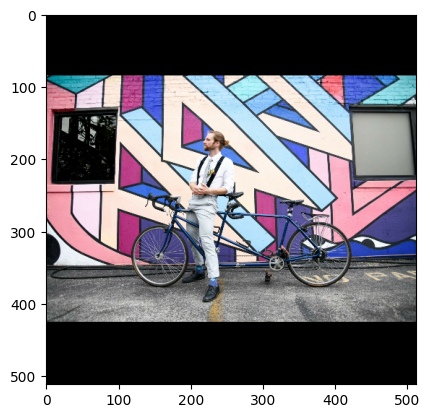

In [27]:
im_test = tf.image.resize_with_pad(tf.io.decode_image(open('second_wedding_tandem.jpeg','rb').read(),channels=3),512,512)/255

fig,ax = plt.subplots()

ax.imshow(im_test)
print(type(im_test))
print(im_test.shape)


outputs = mdl.predict(tf.expand_dims(im_test,axis=0))

In [28]:
outputs

{'boxes': array([[[ 4.47895538e+02,  4.24105865e+02,  5.68181519e+02,
           5.44052917e+02],
         [ 1.27667892e+02, -3.18561859e+01,  6.08355713e+02,
           4.47982727e+02],
         [ 4.47903046e+02,  1.68120956e+02,  5.68131226e+02,
           2.88094299e+02],
         [ 4.47893402e+02,  2.48100067e+02,  5.68162476e+02,
           3.68119690e+02],
         [ 4.47899353e+02,  1.20098419e+02,  5.68149719e+02,
           2.40116211e+02],
         [ 4.47890106e+02,  2.41119080e+01,  5.68143921e+02,
           1.44095718e+02],
         [ 4.47892029e+02,  1.44105606e+02,  5.68155579e+02,
           2.64101837e+02],
         [ 4.47896790e+02,  3.52098755e+02,  5.68146301e+02,
           4.72080963e+02],
         [ 4.47895477e+02,  2.24111969e+02,  5.68153137e+02,
           3.44100922e+02],
         [ 4.47899323e+02,  3.28102600e+02,  5.68146851e+02,
           4.48093201e+02],
         [ 4.47885895e+02,  1.05934143e-01,  5.68162170e+02,
           1.20088684e+02],
         [ 4

In [ ]:
os.chdir('/home/klb807/MARS_project/test/detection/black_top_tfrecords_detection')

train_dataset = glob.glob('./train_dataset*')

# for batch in tf.data.TFRecordDataset(train_dataset).map(decode_fn).take(10):
#     print(batch)

for item in tf.data.TFRecordDataset(train_dataset).map(decode_func).take(1):
    print(item)

In [ ]:
item['image/object/bbox/xmin']

In [ ]:
# from IPython import display

# im = Image.fromarray(image_data)
# im.
# im.show()

im = Image.fromarray(np.squeeze(image_data.numpy()).astype(np.uint8))
im.show()
# draw = ImageDraw.Draw(im)
# output['boxes'][0][0]
# im.size

In [ ]:
256/16

In [ ]:
im.